In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1 Cross-correlation of the cued and uncued tags

In [2]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscorr_time.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Cor EEG/tag'] = crosscorr['value']

Text(0, 0.5, 'Cor EEG/tag')

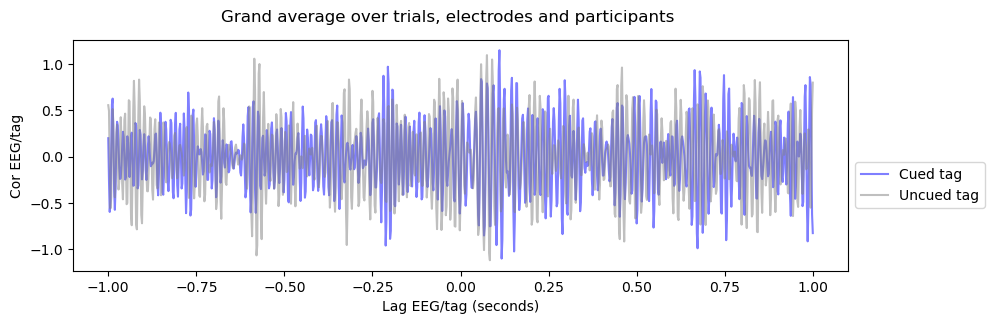

In [3]:
fig, ax = plt.subplots(figsize=(10,3))
average = crosscorr[crosscorr.Cueing == 'Cued'].groupby('Time').value.mean().reset_index()
ax.plot(average.Time, average.value, color='blue', label='Cued tag', alpha=.5)
average = crosscorr[crosscorr.Cueing == 'Uncued'].groupby('Time').value.mean().reset_index()
ax.plot(average.Time, average.value, color='grey', label='Uncued tag', alpha=.5)


plt.suptitle('Grand average over trials, electrodes and participants');

ax.legend(bbox_to_anchor = (1,0.5))
ax.set_xlabel('Lag EEG/tag (seconds)')
ax.set_ylabel('Cor EEG/tag')

### 1.1 Pre-post on cued

In [4]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','prepost']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued']
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-display', 'post': 'Post-display'})



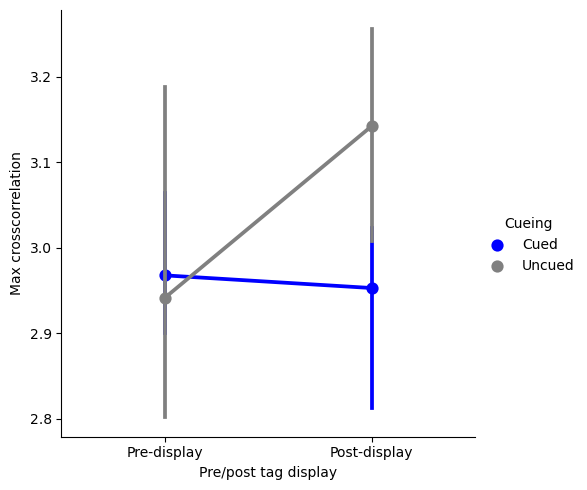

In [5]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display', hue='Cueing', data=crosscorr, kind='point', order=['Pre-display','Post-display'], palette=['blue','grey'])

In [6]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued prepost     value  Max crosscorrelation  Cueing  \
0           A0    1       1  3.023548              3.023548    Cued   
1           A0    1       0  2.900468              2.900468    Cued   
2           A0    0       1  3.008305              3.008305  Uncued   
3           A0    0       0  2.801797              2.801797  Uncued   
4           A1    1       1  3.023056              3.023056    Cued   
5           A1    1       0  2.938608              2.938608    Cued   
6           A1    0       1  3.163719              3.163719  Uncued   
7           A1    0       0  3.187836              3.187836  Uncued   
8           A2    1       1  2.812288              2.812288    Cued   
9           A2    1       0  3.064283              3.064283    Cued   
10          A2    0       1  3.255368              3.255368  Uncued   
11          A2    0       0  2.835165              2.835165  Uncued   

   Pre/post tag display  
0          Post-display  
1           Pre-display 

In [7]:
md = smf.mixedlm("value ~ cued * prepost", crosscorr, groups=crosscorr["participant"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value 
No. Observations:      12          Method:                 REML  
No. Groups:            3           Scale:                  0.0208
Min. group size:       4           Log-Likelihood:         1.9263
Max. group size:       4           Converged:              Yes   
Mean group size:       4.0                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.942    0.083 35.255 0.000  2.778  3.105
cued[T.1]               0.026    0.118  0.223 0.824 -0.204  0.257
prepost[T.1]            0.201    0.118  1.707 0.088 -0.030  0.432
cued[T.1]:prepost[T.1] -0.216    0.166 -1.296 0.195 -0.542  0.110
Group Var               0.000    0.043                           



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### 1.2 Comparing same vs other trials

In [12]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_cueduncued.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','trial_type']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Tags from same trials', 'other': 'Tags from other trials'})



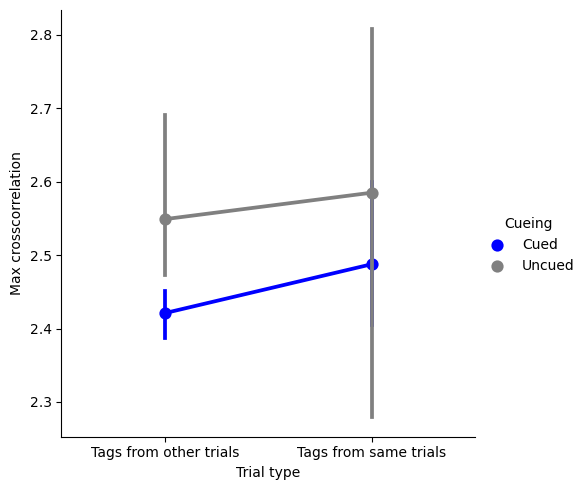

In [13]:
sns.catplot(y='Max crosscorrelation', x='Trial type', hue='Cueing', data=crosscorr, kind='point', units='participant', palette=['blue','grey'], aspect=1)

In [14]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued trial_type     value  Max crosscorrelation  Cueing  \
0           A0    1          1  2.424315              2.424315    Cued   
1           A0    1          0  2.405273              2.405273    Cued   
2           A0    0          1  2.690359              2.690359  Uncued   
3           A0    0          0  2.668666              2.668666  Uncued   
4           A1    1          1  2.387379              2.387379    Cued   
5           A1    1          0  2.599565              2.599565    Cued   
6           A1    0          1  2.473129              2.473129  Uncued   
7           A1    0          0  2.279084              2.279084  Uncued   
8           A2    1          1  2.451331              2.451331    Cued   
9           A2    1          0  2.458140              2.458140    Cued   
10          A2    0          1  2.483443              2.483443  Uncued   
11          A2    0          0  2.807409              2.807409  Uncued   

                Trial type  
0   Tags

In [15]:
md = smf.mixedlm("value ~ cued * trial_type", crosscorr, groups=crosscorr["participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value 
No. Observations:       12           Method:                  REML  
No. Groups:             3            Scale:                   0.0253
Min. group size:        4            Log-Likelihood:          1.1583
Max. group size:        4            Converged:               No    
Mean group size:        4.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  2.585    0.092 28.147 0.000  2.405  2.765
cued[T.1]                 -0.097    0.130 -0.750 0.453 -0.352  0.157
trial_type[T.1]           -0.036    0.130 -0.278 0.781 -0.290  0.218
cued[T.1]:trial_type[T.1] -0.031    0.184 -0.167 0.868 -0.390  0.329
Group Var                  0.000    0.081         

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

## 2 Cross-correlation of the averaged tags 

In [16]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscorr_time_avgtag.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Cor EEG/tag'] = crosscorr['value']

Text(0, 0.5, 'Cor EEG/tag')

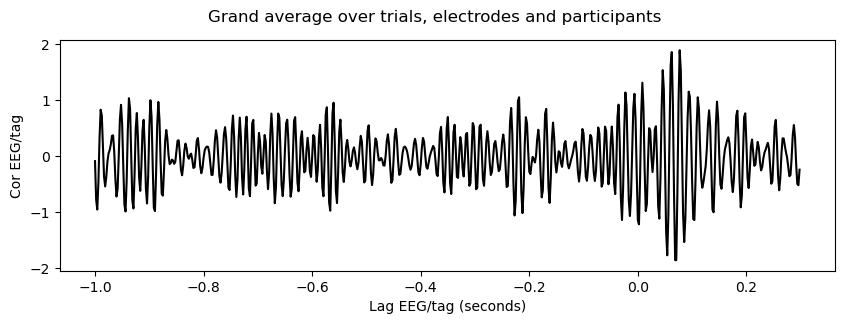

In [17]:
fig, ax = plt.subplots(figsize=(10,3))
average = crosscorr.groupby('Time').value.mean().reset_index()
ax.plot(average.Time, average.value, color='black')


plt.suptitle('Grand average over trials, electrodes and participants');
ax.set_xlabel('Lag EEG/tag (seconds)')
ax.set_ylabel('Cor EEG/tag')

### 2.1 Pre-post on averaged

In [18]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost_avgtag.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr = crosscorr.groupby(['prepost', 'participant'])['value'].mean().reset_index()
crosscorr['Max crosscorrelation'] = crosscorr['value']
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-display', 'post': 'Post-display'})


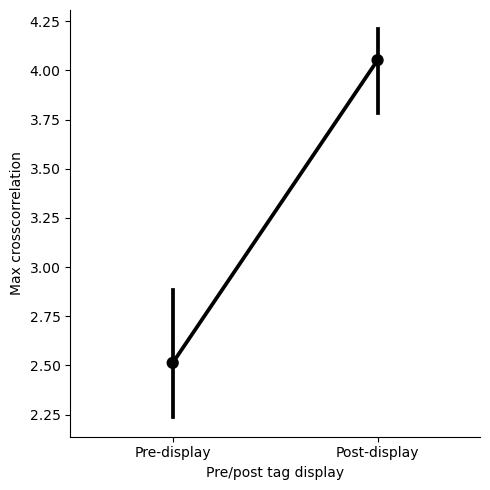

In [19]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display',  data=crosscorr, kind='point', order=['Pre-display','Post-display'], color='black')

In [39]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
print(crosscorr)

  prepost participant     value  Max crosscorrelation Pre/post tag display
0       1          A0  4.164548              4.164548         Post-display
1       1          A1  3.782865              3.782865         Post-display
2       1          A2  4.208232              4.208232         Post-display
3       0          A0  2.420762              2.420762          Pre-display
4       0          A1  2.881686              2.881686          Pre-display
5       0          A2  2.236054              2.236054          Pre-display


In [40]:
md = smf.mixedlm("value ~ prepost", crosscorr, groups=crosscorr["participant"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: value  
No. Observations:  6       Method:             REML   
No. Groups:        3       Scale:              0.0826 
Min. group size:   2       Log-Likelihood:     -1.8009
Max. group size:   2       Converged:          No     
Mean group size:   2.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    2.513    0.167 15.091 0.000  2.186  2.839
prepost[T.1] 1.539    0.235  6.558 0.000  1.079  1.999
Group Var    0.001                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

### 2.2 Comparing same vs other trials

In [2]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_averaged.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','trial_type']).mean().reset_index()
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Tags from same trials', 'other': 'Tags from other trials'})


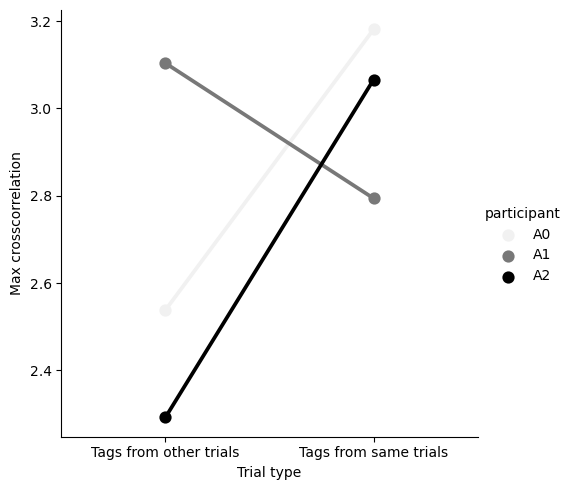

In [3]:
sns.catplot(y='Max crosscorrelation', x='Trial type',  data=crosscorr, kind='point', hue='participant', color='black')

In [47]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
print(crosscorr)

  participant trial_type     value  Max crosscorrelation  \
0          A0          1  2.538265              2.538265   
1          A0          0  3.180837              3.180837   
2          A1          1  3.103514              3.103514   
3          A1          0  2.794058              2.794058   
4          A2          1  2.292677              2.292677   
5          A2          0  3.065627              3.065627   

               Trial type  
0  Tags from other trials  
1   Tags from same trials  
2  Tags from other trials  
3   Tags from same trials  
4  Tags from other trials  
5   Tags from same trials  


In [48]:
md = smf.mixedlm("value ~ trial_type", crosscorr, groups=crosscorr["participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  value  
No. Observations:    6        Method:              REML   
No. Groups:          3        Scale:               0.1062 
Min. group size:     2        Log-Likelihood:      -2.2887
Max. group size:     2        Converged:           Yes    
Mean group size:     2.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        3.014    0.188 16.020 0.000  2.645  3.382
trial_type[T.1] -0.369    0.266 -1.386 0.166 -0.890  0.153
Group Var        0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## 3 Search in subwindows of the tag

In [50]:
from noise_tagging_funs import generate_noise_periods

sfreq = 480 # EEG and tag tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1
tmax_eeg = 2.3

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 45
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq


### 3.1  Timing of the crosscorrelation with the average of the two tags

In [51]:
participants = ['A0', 'A1', 'A2'] 
summed = []
for participant in participants:
    arr_participant = np.load(f'files/averaged_tags_{participant}.npy')
    summed.append(arr_participant)
summed = np.stack(summed)

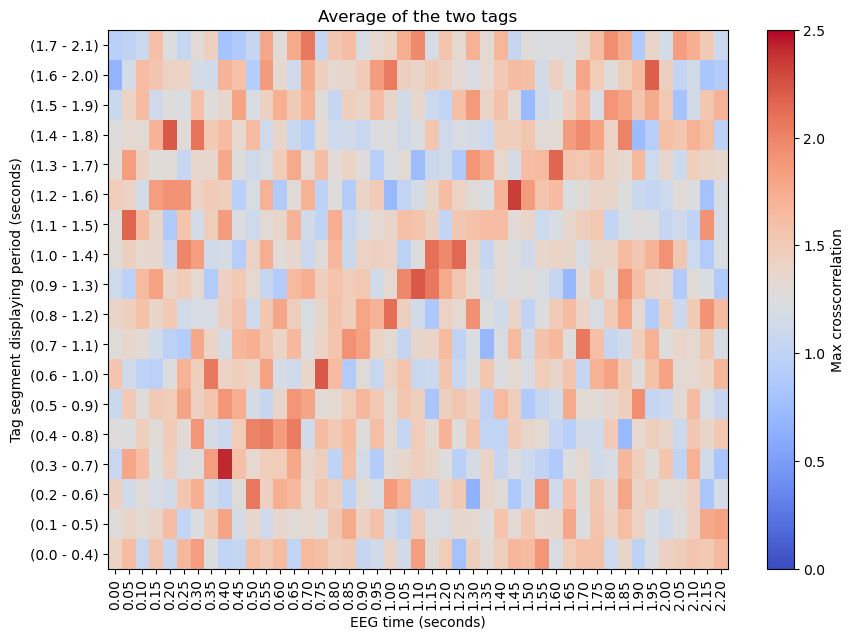

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
avg_summed = summed.mean(axis=0)
cax = ax.imshow(avg_summed, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)

cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax.set_xlabel('EEG time (seconds)')
ax.set_ylabel('Tag segment displaying period (seconds)')
ax.set_title('Average of the two tags')

bin_times = np.linspace(start, end, n_bins)
ax.set_xticks(np.arange(n_bins))
ax.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
ax.set_yticks(np.arange(len(noise_periods)))
ax.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])


plt.show()


In [53]:
idx_noise_periods, idx_bin_times = np.where(summed.mean(axis=0) > 2.2)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f} (zscore = {summed.mean(axis=0)[period, bin]})')

Significant for noise : [1.4 1.8] and bin 0.2 (zscore = 2.218762189986583)
Significant for noise : [1.2 1.6] and bin 1.4 (zscore = 2.34034362733104)
Significant for noise : [0.9 1.3] and bin 1.1 (zscore = 2.2239109741200145)
Significant for noise : [0.6 1. ] and bin 0.7 (zscore = 2.2215218166566597)
Significant for noise : [0.3 0.7] and bin 0.4 (zscore = 2.421775327494569)


### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [54]:
participants = ['A0','A1', 'A2'] 
cued, uncued = [], []
for participant in participants:
    arr_participant = np.load(f'files/cued_tags_with_target_{participant}.npy')
    cued.append(arr_participant)
    arr_participant = np.load(f'files/uncued_tags_with_target_{participant}.npy')
    uncued.append(arr_participant)
cued = np.stack(cued)
uncued = np.stack(uncued)

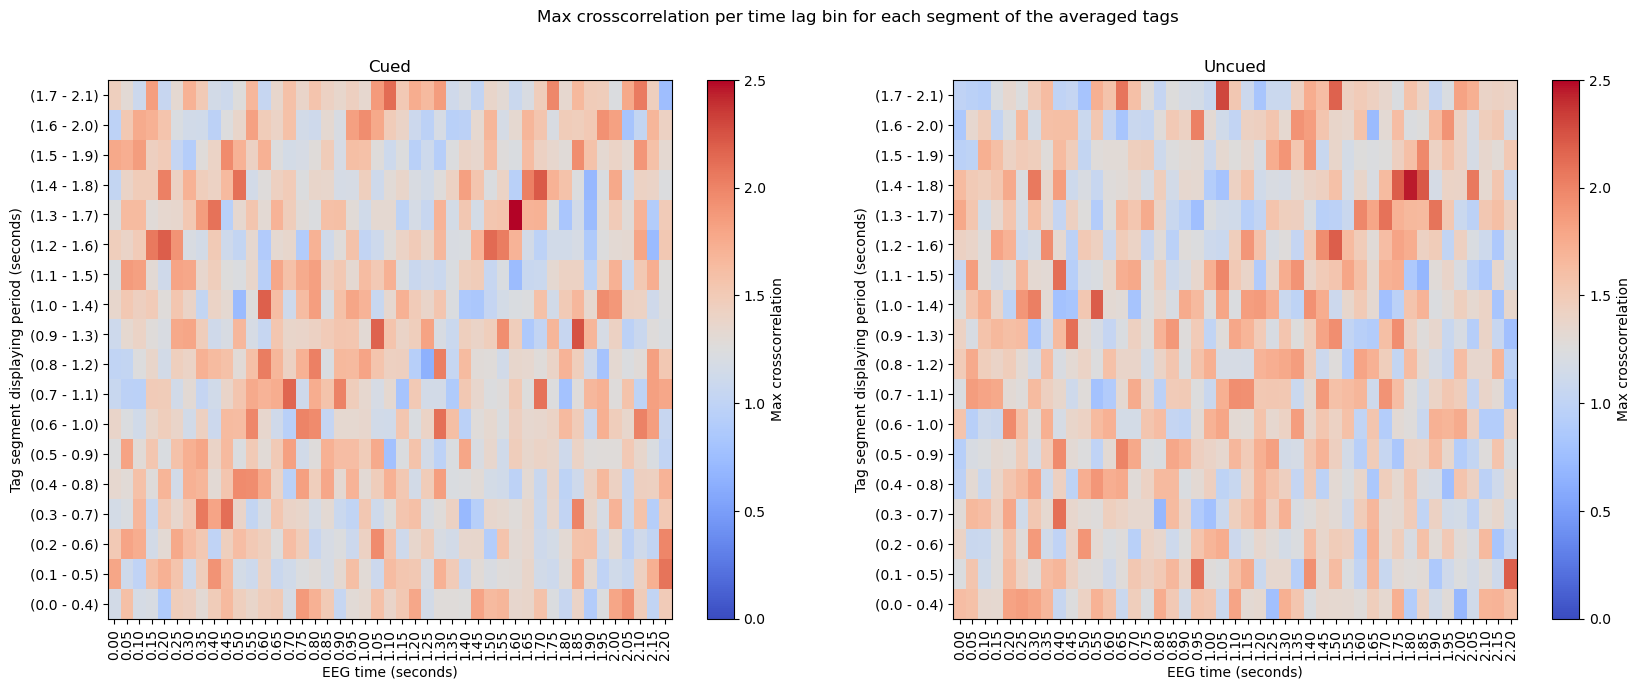

In [55]:
fig, ax = plt.subplots(1,2, figsize=(20,7), sharey=False)
cax = ax[0].imshow(cued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(uncued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

plt.suptitle('Max crosscorrelation per time lag bin for each segment of the averaged tags')

threshold = 1.96
bin_times = np.linspace(start, end, n_bins)
for i, axi in enumerate(ax):
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])
    axi.set_xlabel('EEG time (seconds)')
    axi.set_ylabel('Tag segment displaying period (seconds)')

ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()
plt.show()

In [56]:
idx_noise_periods, idx_bin_times = np.where(cued.mean(axis=0) > 2.2)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Cued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f}  (zscore = {cued.mean(axis=0)[period, bin]})')

[Cued] Significant for noise : [1.4 1.8] and bin 1.7  (zscore = 2.2149508337762467)
[Cued] Significant for noise : [1.3 1.7] and bin 1.6  (zscore = 2.601187044125003)
[Cued] Significant for noise : [0.9 1.3] and bin 1.8  (zscore = 2.2491935099922458)


In [57]:
idx_noise_periods, idx_bin_times = np.where(uncued.mean(axis=0) > 2.2)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Uncued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f}  (zscore = {uncued.mean(axis=0)[period, bin]})')

[Uncued] Significant for noise : [1.7 2.1] and bin 1.0  (zscore = 2.3013948005058222)
[Uncued] Significant for noise : [1.4 1.8] and bin 1.8  (zscore = 2.4421838860213954)
[Uncued] Significant for noise : [1.4 1.8] and bin 1.8  (zscore = 2.226334537472424)
[Uncued] Significant for noise : [1.  1.4] and bin 0.5  (zscore = 2.2029380321478054)
